In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import statistics

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score,r2_score,confusion_matrix,roc_auc_score,f1_score,recall_score,precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

import graphviz
import collections

from tqdm import tqdm
import itertools

# Data

In [4]:
indices_price_excel = pd.read_excel('SW_data/indices_price.xlsx', sheet_name='price', index_col=1, usecols=[0,2,3])

In [2]:
indices_price = indices_price_excel.pivot(columns='ISIN', values='Quote')[['SPI Index', 'SMIMC Index', 'SMCI Index', 'SPIEX Index', 'SPI20 Index']]
indices_price.dropna(inplace=True)
indices_price.head()

NameError: name 'indices_price_excel' is not defined

In [35]:
def price_to_perf(df):
    return (1 + df.pct_change()).cumprod()

In [50]:
benchmark_perf = price_to_perf(indices_price['SPI Index'])

In [7]:
daily_returns = indices_price.pct_change()
daily_returns_cum = (1 + daily_returns).cumprod()

In [8]:
ema_10 = daily_returns_cum.ewm(span=10).mean()
ema_60 = daily_returns_cum.ewm(span=60).mean()
ema_130 = daily_returns_cum.ewm(span=130).mean()

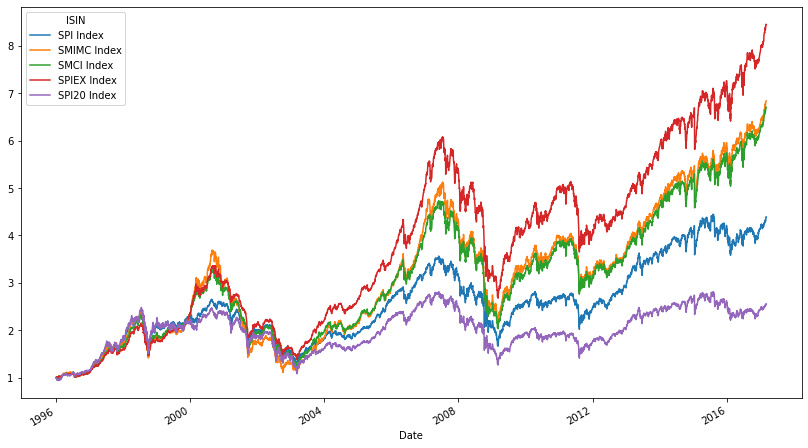

In [9]:
(1+indices_price.pct_change()).cumprod().plot(figsize=(14,8))
plt.show()

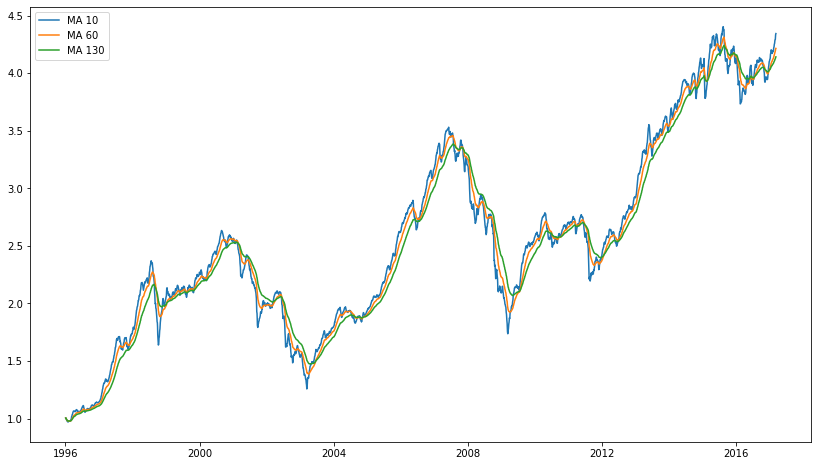

In [10]:
fig = plt.figure(figsize=(14,8))
plt.plot(ema_10['SPI Index'], label='MA 10')
plt.plot(ema_60['SPI Index'], label='MA 60')
plt.plot(ema_130['SPI Index'], label='MA 130')
plt.legend()
plt.show()

In [11]:
best_pred = indices_price.pct_change(periods=30).rank(axis=1).replace({1: 0., 2: 0., 3: 0., 4: 0., 5: 1.}).shift(-30).iloc[180:].dropna()
best_pred = best_pred.asfreq(freq='M', method='ffill')

In [116]:
best_pred

ISIN,SPI Index,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
Date,,,,,
1996-09-30,0.0,0.0,0.0,0.0,1.0
1996-10-31,0.0,1.0,0.0,0.0,0.0
1996-11-30,0.0,1.0,0.0,0.0,0.0
1996-12-31,0.0,1.0,0.0,0.0,0.0
1997-01-31,0.0,0.0,0.0,0.0,1.0
1997-02-28,0.0,0.0,1.0,0.0,0.0
1997-03-31,0.0,0.0,0.0,0.0,1.0
1997-04-30,0.0,1.0,0.0,0.0,0.0
1997-05-31,0.0,0.0,0.0,0.0,1.0


In [145]:
x = []
for i in best_pred.index:
    df_ret = indices_price.loc[:i]
    df_ret = df_ret.iloc[-180:].pct_change().fillna(0)
    df_ret_cum = (1 + df_ret).cumprod()
    df_ema_10 = df_ret_cum.ewm(span=10).mean()
    df_ema_60 = df_ret_cum.ewm(span=60).mean()
    df_ema_130 = df_ret_cum.ewm(span=130).mean()
    x_temp = pd.concat([df_ema_10, df_ema_60, df_ema_130], axis=1).dropna()
    x.append(x_temp.values)

In [146]:
X = np.array(x)
y = np.array(best_pred)

In [147]:
nsamples, nx, ny = X.shape
X = X.reshape((nsamples, nx * ny))

In [148]:
np.shape(X)

(244, 2700)

In [149]:
np.shape(y)

(244, 5)

In [150]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.5, shuffle=True, stratify=y)

In [151]:
split_index = len(y) // 2
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[:split_index:]

In [72]:
split_date = str(best_pred.iloc[split_index].name)
split_date

'2006-11-30 00:00:00'

# Models

In [30]:
def pred_to_perf(df_pred):
    first_date = df_pred.index[0]
    return (1 + (df_pred.reindex(daily_returns[first_date:].index, method='ffill').shift(1) * daily_returns[first_date:]).sum(axis=1)).cumprod()

In [153]:
n_split = 5

### KNN

In [154]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('knn_model', KNeighborsClassifier()))
pipeline = Pipeline(estimators)

In [155]:
# number of neighbors K
knn_grid = {'knn_model__n_neighbors' : list(range(2, 30, 2)),
            'knn_model__weights'     : ['uniform', 'distance'],
            'knn_model__algorithm'   : ['auto', 'ball_tree', 'kd_tree', 'brute']}

# Cross validation search with all combination of parameters possible 
knn_cv = GridSearchCV(pipeline, knn_grid, n_jobs = -1, verbose = 1)
knn_cv.fit(X_train,y_train)

print(knn_cv.best_params_)
best_param_knn = list(knn_cv.best_params_.values())

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s


{'knn_model__algorithm': 'auto', 'knn_model__n_neighbors': 2, 'knn_model__weights': 'distance'}


[Parallel(n_jobs=-1)]: Done 545 out of 560 | elapsed:    4.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:    4.7s finished


In [156]:
best_algo, best_K, best_weights = best_param_knn

pipeline.set_params(knn_model__n_neighbors = best_K, knn_model__weights = best_weights)
pipeline.fit(X_train, y_train)

y_hat_knn_train = pipeline.predict(X_train)
y_hat_knn_test = pipeline.predict(X_test)
df_pred_knn = pd.DataFrame(data=y_hat_knn_test, columns=indices_price.columns, index=best_pred[split_index:].index)

In [157]:
print('Accuracy on train set', round( 100* accuracy_score(y_hat_knn_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * accuracy_score(y_hat_knn_test, y_test), 2), '%')

Accuracy on train set 100.0 %
Accuracy on test set 27.87 %


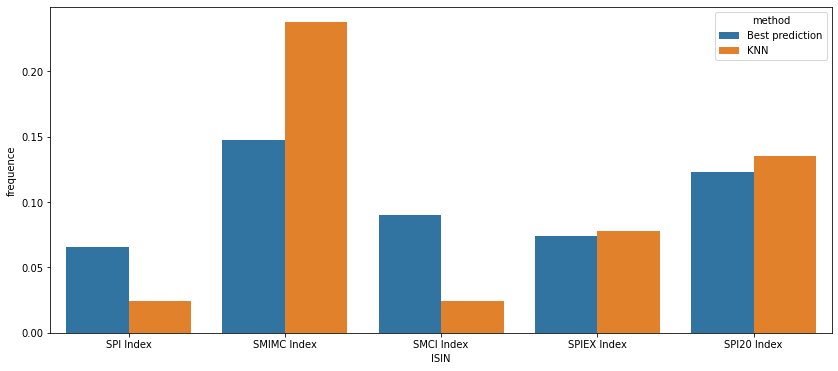

In [158]:
fig = plt.figure(figsize=(14,6))
df_results = pd.concat([best_pred[split_index:].sum(axis=0) / len(y), df_pred_knn.sum(axis=0) / len(y)], axis=1).rename(columns={0:'Best prediction', 1:'KNN'})
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='ISIN', var_name='method', value_name='frequence')
sns.barplot(data=df_results, x='ISIN', y='frequence', hue='method')
plt.show()

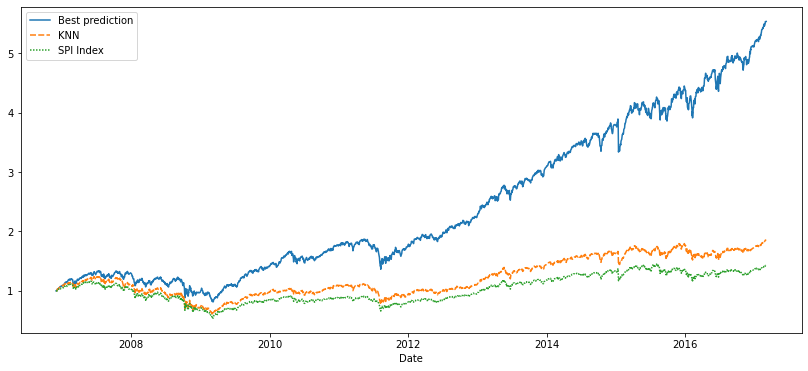

In [159]:
fig = plt.figure(figsize=(14,6))
df_results_plot = pd.concat([pred_to_perf(best_pred[split_index:]), pred_to_perf(df_pred_knn)], axis=1).rename(columns={0:'Best prediction', 1:'KNN'})
sns.lineplot(data=pd.concat([df_results_plot, price_to_perf(indices_price['SPI Index'][split_date:])], axis=1))
plt.show()

### Decision Tree

In [160]:
# Maximum number of levels in tree
dt_max_depth = list(range(10,20))
dt_max_depth.append(None)

# Minimum number of samples required to be at a leaf node
dt_min_samples_leaf = list(range(2,5))

# Minimum number of samples required to split a node
dt_min_samples_split = list(range(2,5))

dt_criterion = ['entropy', 'gini']

dt_grid = {'max_depth'        : dt_max_depth,
           'min_samples_leaf' : dt_min_samples_leaf,
           'min_samples_split': dt_min_samples_split,
           'criterion'        : dt_criterion }

print('length of the grid', len(dt_max_depth) * len(dt_min_samples_leaf) * len(dt_min_samples_split) * len(dt_criterion))

length of the grid 198


In [161]:
dt_default = DecisionTreeClassifier()

# Create the random search for a Random Forest model
dt_cv = GridSearchCV(estimator = dt_default, param_grid = dt_grid, 
                            cv = n_split, verbose = 2, n_jobs = -1)
dt_cv.fit(X_train,y_train)

print(dt_cv.best_params_)
best_param_dt = list(dt_cv.best_params_.values())

Fitting 5 folds for each of 198 candidates, totalling 990 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 990 out of 990 | elapsed:   56.8s finished


{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [162]:
best_criterion, best_max_depth, best_samples_leaf, best_samples_split  = best_param_dt

dt = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_max_depth,
                             min_samples_split=best_samples_split,
                             min_samples_leaf=best_samples_leaf) 

dt = dt.fit(X_train, y_train)
y_hat_dt_train = dt.predict(X_train)
y_hat_dt_test = dt.predict(X_test)
df_pred_dt = pd.DataFrame(data=y_hat_dt_test, columns=indices_price.columns, index=best_pred[split_index:].index)

In [163]:
print('Accuracy on train set', round( 100* accuracy_score(y_hat_dt_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * accuracy_score(y_hat_dt_test, y_test), 2), '%')

Accuracy on train set 83.61 %
Accuracy on test set 19.67 %


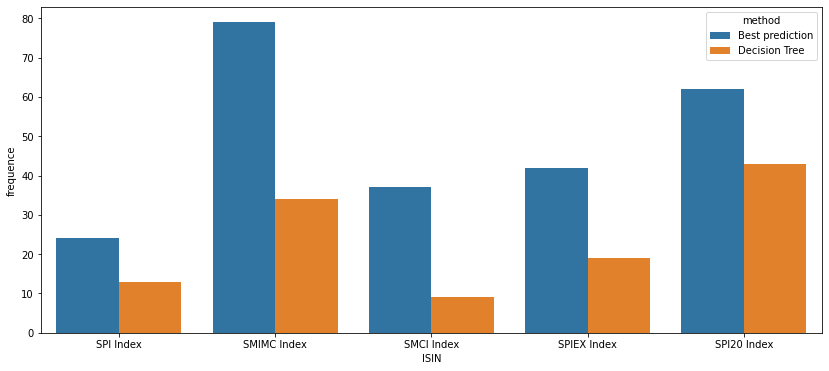

In [164]:
fig = plt.figure(figsize=(14,6))
df_results = pd.concat([best_pred.sum(axis=0), df_pred_dt.sum(axis=0)], axis=1).rename(columns={0:'Best prediction', 1:'Decision Tree'})
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='ISIN', var_name='method', value_name='frequence')
sns.barplot(data=df_results, x='ISIN', y='frequence', hue='method')
plt.show()

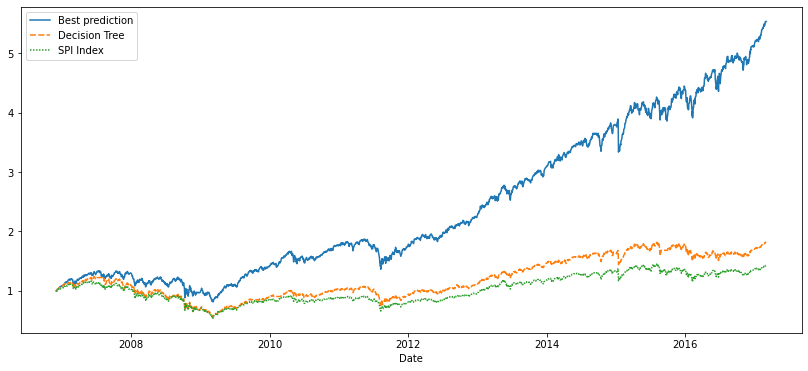

In [166]:
fig = plt.figure(figsize=(14,6))
df_results_plot = pd.concat([pred_to_perf(best_pred[split_index:]), pred_to_perf(df_pred_dt)], axis=1).rename(columns={0:'Best prediction', 1:'Decision Tree'})
sns.lineplot(data=pd.concat([df_results_plot, price_to_perf(indices_price['SPI Index'][split_date:])], axis=1))
plt.show()

### Random Forest

In [167]:
# Number of trees in Random Forest
rf_n_estimators = list(range(100,250,10))

# Maximum number of levels in tree
rf_max_depth = list(range(10,20))
rf_max_depth.append(None)

# Minimum number of samples required to be at a leaf node
rf_min_samples_leaf = list(range(1,5))

# Minimum number of samples required to split a node
rf_min_samples_split = list(range(1,5))

rf_grid = {'n_estimators'     : rf_n_estimators,
           'max_depth'        : rf_max_depth, 
           'min_samples_leaf' : rf_min_samples_leaf, 
           'min_samples_split': rf_min_samples_split }

In [168]:
rf_default = RandomForestClassifier()

rf_random_cv = RandomizedSearchCV(estimator = rf_default, param_distributions = rf_grid, 
                               n_iter = 100, cv = n_split, verbose = 1, 
                               n_jobs = -1)
rf_random_cv.fit(X_train,y_train)

print(rf_random_cv.best_params_)
best_param_rf = list(rf_random_cv.best_params_.values())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   47.9s finished


{'n_estimators': 110, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 11}


In [169]:
best_estimators, best_samples_split, best_samples_leaf, best_max_depth,  = best_param_rf

# rfc = RandomForestClassifier(criterion='gini', max_features = None, max_depth = best_max_depth,
#                             n_estimators= best_estimators, min_samples_leaf = best_samples_leaf,
#                             min_samples_split = best_samples_split)
rfc = RandomForestClassifier(criterion='gini', max_features = None, max_depth = None,
                             n_estimators= 1000)


rfc = rfc.fit(X_train, y_train)
y_hat_rfc_train = rfc.predict(X_train)
y_hat_rfc_test = rfc.predict(X_test)
df_pred_rfc = pd.DataFrame(data=y_hat_rfc_test, columns=indices_price.columns, index=best_pred[split_index:].index)

In [170]:
print('Accuracy on train set', round( 100* accuracy_score(y_hat_rfc_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * accuracy_score(y_hat_rfc_test, y_test), 2), '%')

Accuracy on train set 100.0 %
Accuracy on test set 6.56 %


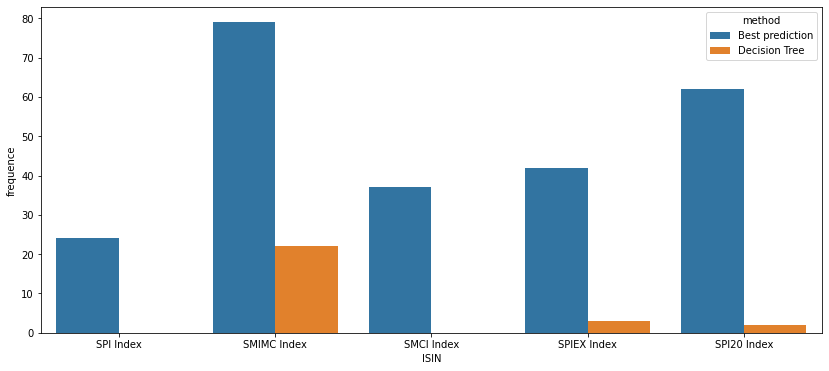

In [171]:
fig = plt.figure(figsize=(14,6))
df_results = pd.concat([best_pred.sum(axis=0), df_pred_rfc.sum(axis=0)], axis=1).rename(columns={0:'Best prediction', 1:'Decision Tree'})
df_results = df_results.reset_index()
df_results = df_results.melt(id_vars='ISIN', var_name='method', value_name='frequence')
sns.barplot(data=df_results, x='ISIN', y='frequence', hue='method')
plt.show()

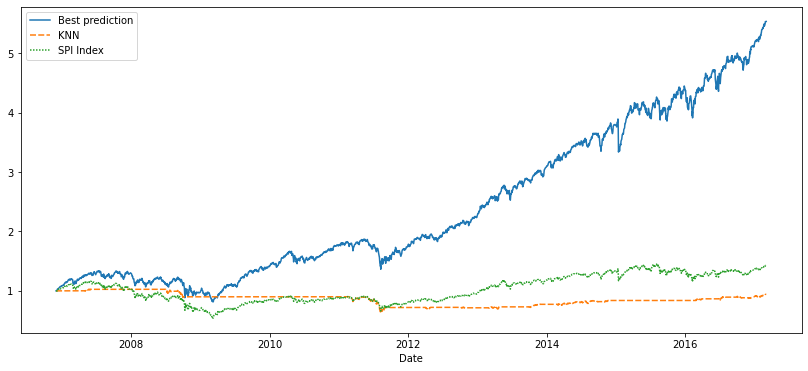

In [172]:
fig = plt.figure(figsize=(14,6))
df_results_plot = pd.concat([pred_to_perf(best_pred[split_index:]), pred_to_perf(df_pred_rfc)], axis=1).rename(columns={0:'Best prediction', 1:'KNN'})
sns.lineplot(data=pd.concat([df_results_plot, price_to_perf(indices_price['SPI Index'][split_date:])], axis=1))
plt.show()

# Neural Network

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import torch
from torch import nn
from torch.nn import functional as F
from itertools import combinations

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## DATA

In [3]:
indices_price_excel = pd.read_excel('SW_data/indices_price.xlsx', sheet_name='price', index_col=1, usecols=[0,2,3])

In [4]:
indices_price = indices_price_excel.pivot(columns='ISIN', values='Quote')[['SPI Index', 'SMIMC Index', 'SMCI Index', 'SPIEX Index', 'SPI20 Index']]
indices_price.dropna(inplace=True)

In [5]:
daily_returns = indices_price.pct_change()
daily_returns_cum = (1 + daily_returns).cumprod()

In [6]:
input_period = 90

In [7]:
best_pred = indices_price.pct_change(periods=30).rank(axis=1).replace({1: 0., 2: 0., 3: 0., 4: 0., 5: 1.}).shift(-30).iloc[input_period:].dropna()
best_pred = best_pred.asfreq(freq='M', method='ffill')

In [8]:
# simple cumulative returns
x = []
for i in best_pred.index:
    df_price = indices_price.loc[:i]
    df_ret = df_price.iloc[-input_period:].pct_change().fillna(0)
    df_ret_cum = (1 + df_ret).cumprod()
    x.append(df_ret_cum.values)

In [10]:
# EMA difference within each indice
x = []
for i in best_pred.index:
    df_price = indices_price.loc[:i]
    df_ret = df_price.iloc[-input_period:].pct_change().fillna(0)
    df_ret_cum = (1 + df_ret).cumprod()
    df_ema_10 = df_ret_cum.ewm(span=10).mean()
    df_ema_130 = df_ret_cum.ewm(span=130).mean()
    df_input = df_ema_130 - df_ema_10
    x.append(df_input.values)

In [10]:
# EMA diff between each indices
# taking account of t=0 data
x = []
cc = [p for p in itertools.permutations(daily_returns.columns, 2)]
df_price = indices_price
df_ret = df_price.pct_change().fillna(0)
df_ret_cum = (1 + df_ret).cumprod()
df_ret_diff = pd.concat([df_ret[c[1]].sub(df_ret[c[0]]) for c in cc], axis=1, keys=cc)
df_ret_diff_cum = (1 + df_ret_diff).cumprod()
df_ema_10 = df_ret_diff_cum.ewm(span=10).mean()
df_ema_130 = df_ret_diff_cum.ewm(span=130).mean()
df_input = df_ema_130 - df_ema_10
for i in best_pred.index:
    df_input = df_input.loc[:i]
    df_input = df_input.iloc[-input_period:]
    x.append(df_input.values)

In [11]:
# EMA diff between each indices
# reseting data at t=0 at each sample
x = []
cc = [p for p in itertools.permutations(daily_returns.columns, 2)]
for i in best_pred.index:
    df_price = indices_price.loc[:i]
    df_ret = df_price.iloc[-input_period:].pct_change().fillna(0)
    df_ret_cum = (1 + df_ret).cumprod()
    df_ret_diff = pd.concat([df_ret[c[1]].sub(df_ret[c[0]]) for c in cc], axis=1, keys=cc)
    df_ret_diff_cum = (1 + df_ret_diff).cumprod()
    df_ema_10 = df_ret_diff_cum.ewm(span=10).mean()
    df_ema_130 = df_ret_diff_cum.ewm(span=130).mean()
    x_temp = df_ema_130 - df_ema_10
    x.append(x_temp.values)

In [11]:
X = np.array(x)
y = np.array(best_pred)

In [12]:
print(np.shape(X))
print(np.shape(y))

(248, 90, 5)
(248, 5)


In [13]:
# split_index = len(y) // 2
split_index = 200
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[:split_index:]
X_test = X_test[:-8]
y_test = y_test[:-8]

In [14]:
print(X_train.shape)
print(X_test.shape)

(200, 90, 5)
(40, 90, 5)


In [15]:
X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

train_mean = X_train.mean(dim=[1], keepdim=True)
train_std = X_train.std(dim=[1], keepdim=True)
X_train = X_train.sub_(train_mean).div_(train_std)

test_mean = X_test.mean(dim=[1], keepdim=True)
test_std = X_test.std(dim=[1], keepdim=True)
X_test = X_test.sub_(test_mean).div_(test_std)

train_size = X_train.size(0)
shuffle_idx = torch.randperm(train_size)
X_train = X_train[shuffle_idx, :, :]
y_train = y_train[shuffle_idx, :]

## Models

In [16]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(1800, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 5)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        x = self.sigmoid(x)
        
        return x

In [17]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(30, 4))
        # 32 x (90 - 29) x (20 - 3) = 16 x 61 x 17 => 16 x 30 x 8
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(7, 2))
        # 64 x (30 - 6) x (8 - 1) = 32 x 24 x 7 => 32 * 12 * 3
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(1152, 64)
        self.fc2 = nn.Linear(64, 5)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.drop = nn.Dropout(0.1)
        self.drop2d = nn.Dropout2d(0.1)

    def forward(self, x):
        
        x = x.view(-1, 1, x.size(1), x.size(2))
    
        x = self.relu(self.pool(self.drop2d(self.conv1(x))))

        # x = self.relu(self.conv2(x))
        x = self.relu(self.pool(self.drop2d(self.conv2(x))))
        #print(x.shape)
        x = x.flatten(start_dim=1)

        x = self.relu(self.drop(self.fc1(x)))
        # x = self.relu(self.drop(self.fc2(x)))
        x = self.sigmoid(self.fc2(x))

        return x

In [18]:
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(5, 5))
        # 32 x (180 - 4) x (20 - 4) = 16 x 176 x 16 => 16 x 88 x 8
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3))
        # 64 x (88 - 2) x (8 - 2) = 32 x 86 x 6 => 32 * 43 * 3
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(4128, 64)
        self.fc2 = nn.Linear(64, 5)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.drop = nn.Dropout(0.5)
        self.drop2d = nn.Dropout2d(0.3)

    def forward(self, x):
        
        x = x.view(-1, 1, x.size(1), x.size(2))
    
        x = self.relu(self.pool(self.drop2d(self.conv1(x))))

        # x = self.relu(self.conv2(x))
        x = self.relu(self.pool(self.drop2d(self.conv2(x))))

        x = x.flatten(start_dim=1)

        x = self.relu(self.drop(self.fc1(x)))
        # x = self.relu(self.drop(self.fc2(x)))
        x = self.sigmoid(self.fc2(x))

        return x

In [19]:
def output_to_accu(model, X, y):
    nb_errors = 0
    for b in range(0, X.size(0)):
        output = model(X.narrow(0, b, 1))
        _, predicted_classes = output.max(1)
        for k in range(1):
            if y[b + k, predicted_classes[k]] != 1.:
                nb_errors = nb_errors + 1
    accuracy = 100 * (1 - nb_errors / X.size(0))
    return accuracy

In [20]:
def output_to_loss(model, X, y):
    nb_errors = 0
    loss = 0
    criterion = nn.BCELoss()
    for b in range(0, X.size(0)):
        output = model(X.narrow(0, b, 1))
        loss += criterion(output, y.narrow(0, b, 1))
        
    return loss

In [21]:
def pred_to_perf(df_pred):
    first_date = df_pred.index[0]
    return (1 + (df_pred.reindex(daily_returns[first_date:].index, method='ffill').shift(1) * daily_returns[first_date:]).sum(axis=1)).cumprod()

In [22]:
def price_to_perf(df):
    return (1 + df.pct_change()).cumprod()

In [51]:
model = ConvNet()

# criterion = nn.MSELoss()
criterion = nn.BCELoss()

eta = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
mini_batch_size = 10
nb_epochs = 20

train_accu_list = []
test_accu_list = []

train_loss_list = []
test_loss_list =[]
for e in range(nb_epochs):
    
    acc_loss = 0
    model.train()
    
    for b in range(0, X_train.size(0), mini_batch_size):
        optimizer.zero_grad()
        
        output = model(X_train.narrow(0, b, mini_batch_size))
        loss = criterion(output, y_train.narrow(0, b, mini_batch_size))
        acc_loss = acc_loss + loss.item()
        loss.backward()
        
        optimizer.step()
    
    model.eval()
    train_accu = output_to_accu(model, X_train, y_train)
    train_accu_list.append(train_accu)
    test_accu = output_to_accu(model, X_test, y_test)
    test_accu_list.append(test_accu)
    
    train_loss = output_to_loss(model, X_train, y_train)
    train_loss_list.append(train_loss)
    test_loss = output_to_loss(model, X_test, y_test)
    test_loss_list.append(test_loss)
    
    if e % 2 == 0:
        print('epoch', e + 1, ':', acc_loss)

RuntimeError: Calculated padded input size per channel: (30 x 1). Kernel size: (7 x 2). Kernel size can't be greater than actual input size

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.plot(list(range(nb_epochs)), train_accu_list, label='Train accuracy')
plt.plot(list(range(nb_epochs)), test_accu_list, label='Test accuracy')
plt.legend()
plt.grid()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (20,) and (0,)

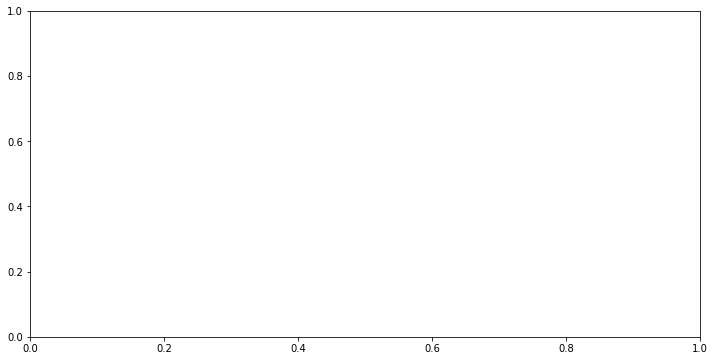

In [52]:
fig = plt.figure(figsize=(12,6))
plt.plot(list(range(nb_epochs)), train_loss_list, label='Train loss')
plt.plot(list(range(nb_epochs)), test_loss_list, label='Test loss')
plt.legend()
plt.grid()
plt.show()

In [43]:
class LSTM(nn.Module):

    def __init__(self, input_size, output_size, hidden_size=5, num_layers=2, dropout=0):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h0 = torch.randn(num_layers, x.size(0), hidden_size)
        c0 = torch.randn(num_layers, x.size(0), hidden_size)
        x, _ = self.lstm(x, (h0, c0))
        x = self.relu(x)
        x = self.sigmoid(self.fc(x[:, -1, :]))
        
        return x

In [44]:
mini_batch_size = 20
hidden_size = 10
num_layers = 5
input_size = X_train.size(2)
output_size = 5
dropout = 0
nb_epochs = 10
eta = 1e-3

model = LSTM(input_size=input_size, output_size=output_size, hidden_size=hidden_size, num_layers=num_layers)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

train_accu_list = []
test_accu_list = []
train_loss_list = []
test_loss_list = []

#h = torch.randn(num_layers, mini_batch_size, hidden_size)
#c = torch.randn(num_layers, mini_batch_size, hidden_size)
    
for e in range(nb_epochs):
    
    acc_loss = 0
    
    for b in range(0, X_train.size(0), mini_batch_size):
        
        optimizer.zero_grad()
        
        input = X_train.narrow(0, b, mini_batch_size)
        
        output = model(input)
        
        #output, (h, c) = rnn(input, (h, c))
        
        loss = criterion(output, y_train.narrow(0, b, mini_batch_size))
        loss.backward(retain_graph=True)

        acc_loss = acc_loss + loss.item()
        
        optimizer.step()
        
    model.eval()
    
    train_accu = output_to_accu(model, X_train, y_train)
    train_accu_list.append(train_accu)
    test_accu = output_to_accu(model, X_test, y_test)
    test_accu_list.append(test_accu)
    
    train_loss = output_to_loss(model, X_train, y_train)
    train_loss_list.append(train_loss)
    test_loss = output_to_loss(model, X_test, y_test)
    test_loss_list.append(test_loss)
    
    model.train()
    
    if e % 1 == 0:
        print('epoch', e + 1, ':', acc_loss)

epoch 1 : 7.034771502017975
epoch 2 : 6.959093868732452
epoch 3 : 6.883860409259796
epoch 4 : 6.797182321548462
epoch 5 : 6.684409439563751
epoch 6 : 6.554068386554718
epoch 7 : 6.404887855052948
epoch 8 : 6.236539900302887
epoch 9 : 6.066767930984497
epoch 10 : 5.9111239314079285


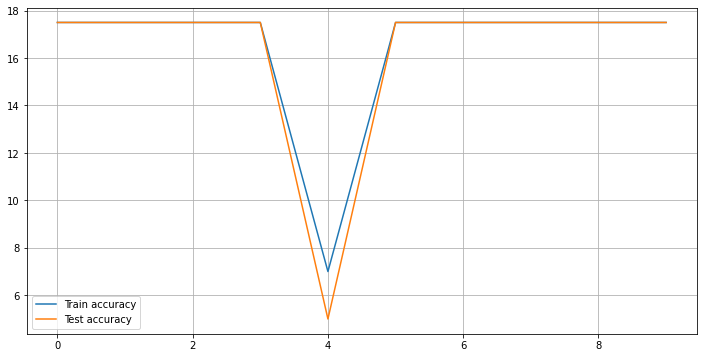

In [45]:
fig = plt.figure(figsize=(12,6))
plt.plot(list(range(nb_epochs)), train_accu_list, label='Train accuracy')
plt.plot(list(range(nb_epochs)), test_accu_list, label='Test accuracy')
plt.legend()
plt.grid()
plt.show()

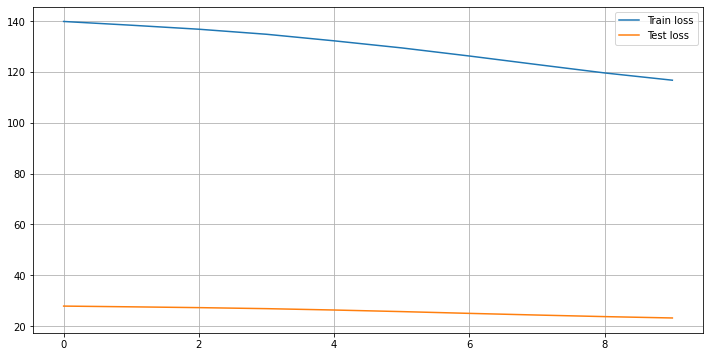

In [46]:
fig = plt.figure(figsize=(12,6))
plt.plot(list(range(nb_epochs)), train_loss_list, label='Train loss')
plt.plot(list(range(nb_epochs)), test_loss_list, label='Test loss')
plt.legend()
plt.grid()
plt.show()

In [47]:
nb_errors = 0
mini_batch_size = 1
output_list = []
prediction_train = np.zeros((X_train.size(0), y_train.size(1)))
model.eval()

for b in range(0, X_train.size(0), mini_batch_size):
    output = model(X_train.narrow(0, b, mini_batch_size))
    output_list.append(output)
    _, predicted_classes = output.max(1)
    for k in range(mini_batch_size):
        prediction_train[b, predicted_classes[k]] = 1
        if y_train[b + k, predicted_classes[k]] != 1.:
            nb_errors = nb_errors + 1
    
print('accuracy on train set: {:0.2f}%'.format(100 - (100 * nb_errors) / X_train.size(0)))

accuracy on train set: 17.50%


In [48]:
nb_errors = 0
mini_batch_size = 1
output_list = []
prediction_test = np.zeros((X_test.size(0), y_test.size(1)))
prediction_rank = []
model.eval()

for b in range(0, X_test.size(0), mini_batch_size):
    output = model(X_test.narrow(0, b, mini_batch_size))
    output_list.append(output)
    prediction_rank.append(np.array(torch.sort(output)[1]).reshape(-1))
    _, predicted_classes = output.max(1)
    for k in range(mini_batch_size):
        prediction_test[b, predicted_classes[k]] = 1
        if y_test[b + k, predicted_classes[k]] != 1.:
            nb_errors = nb_errors + 1
prediction_rank = np.array(prediction_rank)
print('accuracy on test set: {:0.2f}%'.format(100 - (100 * nb_errors) / X_test.size(0)))

accuracy on test set: 17.50%


In [49]:
X_test[:2, :5]

tensor([[[0.7872, 0.6881, 0.6791, 0.6720, 0.8316],
         [0.7726, 0.6787, 0.6710, 0.6648, 0.8151],
         [0.7735, 0.7018, 0.6875, 0.6825, 0.8144],
         [0.7677, 0.7115, 0.6947, 0.6883, 0.8058],
         [0.8087, 0.7742, 0.7514, 0.7453, 0.8444]],

        [[1.0468, 1.1128, 1.0456, 1.0203, 1.0659],
         [1.0547, 1.1241, 1.0565, 1.0309, 1.0733],
         [1.0607, 1.1275, 1.0602, 1.0328, 1.0792],
         [1.1167, 1.1750, 1.1136, 1.0797, 1.1371],
         [1.1450, 1.1992, 1.1372, 1.0981, 1.1673]]])

In [50]:
output_list[:2]

[tensor([[0.3731, 0.3486, 0.3845, 0.4211, 0.4035]], grad_fn=<SigmoidBackward>),
 tensor([[0.3731, 0.3486, 0.3845, 0.4211, 0.4035]], grad_fn=<SigmoidBackward>)]

In [31]:
df_pred_convnet = pd.DataFrame(data=prediction_test, columns=indices_price.columns, index=best_pred[208:].index)

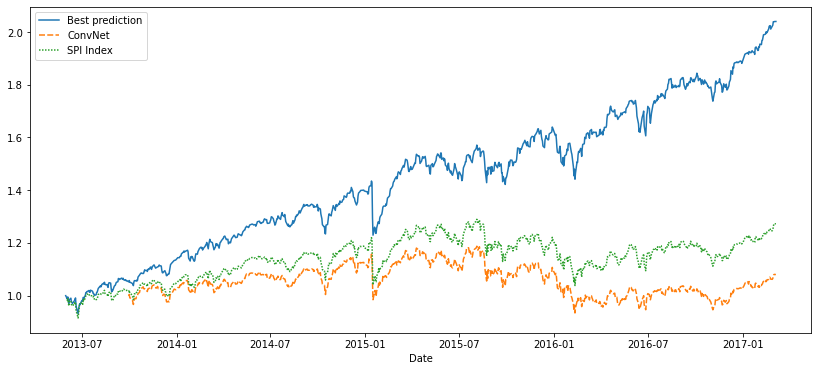

In [32]:
fig = plt.figure(figsize=(14,6))
split_date = str(best_pred.iloc[208].name)
df_results_plot = pd.concat([pred_to_perf(best_pred[208:]), pred_to_perf(df_pred_convnet)], axis=1).rename(columns={0:'Best prediction', 1:'ConvNet'})
sns.lineplot(data=pd.concat([df_results_plot, price_to_perf(indices_price['SPI Index'][split_date:])], axis=1))
plt.show()

In [535]:
model = MLP()

# criterion = nn.MSELoss()
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

eta = 5e-1
mini_batch_size = 5
nb_epochs = 20

for e in range(nb_epochs):
    acc_loss = 0

    for b in range(0, X_train.size(0), mini_batch_size):
        output = model(X_train.narrow(0, b, mini_batch_size))
        loss = criterion(output, y_train.narrow(0, b, mini_batch_size))
        acc_loss = acc_loss + loss.item()
        # print(output)
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            for p in model.parameters():
                p -= eta * p.grad

    print('epoch', e + 1, ':', acc_loss)

epoch 1 : 16.554613947868347
epoch 2 : 14.862844556570053
epoch 3 : 14.55127876996994
epoch 4 : 14.298196792602539
epoch 5 : 14.190958470106125
epoch 6 : 13.97439643740654
epoch 7 : 13.738138943910599
epoch 8 : 13.736871615052223
epoch 9 : 13.610996589064598
epoch 10 : 13.259048476815224
epoch 11 : 13.33023227751255
epoch 12 : 13.458964869379997
epoch 13 : 12.949641302227974
epoch 14 : 12.57250814139843
epoch 15 : 13.025222438387573
epoch 16 : 12.62768642604351
epoch 17 : 13.049843000248075
epoch 18 : 13.045604780316353
epoch 19 : 13.58894558250904
epoch 20 : 12.445861880667508


# Trading strategie

In [64]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

In [65]:
indices_price_excel = pd.read_csv('SW_data/prices.csv', index_col=0, parse_dates=True)

In [66]:
indices_price = indices_price_excel[['SPI Index', 'SMIMC Index', 'SMCI Index', 'SPIEX Index', 'SPI20 Index']]
indices_price.dropna(inplace=True)

In [67]:
daily_returns = indices_price.pct_change()
daily_returns = daily_returns[daily_returns.columns[1:]]
daily_returns_cum = (1 + daily_returns).cumprod()

In [68]:
df_price

,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
1996-01-04,426.47,2049.35,423.28,3395.80
1996-01-05,426.04,2054.88,424.38,3376.10
1996-01-06,426.04,2054.88,424.38,3376.10
1996-01-07,426.04,2054.88,424.38,3376.10
1996-01-08,427.94,2071.98,427.67,3368.10
...,...,...,...,...
2021-10-21,5036.42,23314.25,6009.04,11990.91
2021-10-22,5050.40,23417.89,6030.56,12006.71
2021-10-23,5050.40,23417.89,6030.56,12006.71
2021-10-24,5050.40,23417.89,6030.56,12006.71


In [69]:
cc = [p for p in itertools.permutations(daily_returns.columns, 2)]
df_price = indices_price[indices_price.columns[1:]]
df_ret = df_price.pct_change().fillna(0)
df_ret_cum = (1 + df_ret).cumprod()
df_ret_diff = pd.concat([df_ret[c[1]].sub(df_ret[c[0]]) for c in cc], axis=1, keys=cc)
df_ret_diff_cum = (1 + df_ret_diff).cumprod()
df_ema_10 = df_ret_diff_cum.ewm(span=10).mean()
df_ema_130 = df_ret_diff_cum.ewm(span=130).mean()
df_ema_diff = df_ema_10 - df_ema_130

In [95]:
df_ema_diff.head(10)

SMIMC Index                          SMCI Index              \
            SMCI Index SPIEX Index SPI20 Index SMIMC Index SPIEX Index   
1996-01-04    0.000000    0.000000    0.000000    0.000000    0.000000   
1996-01-05    0.000171    0.000166   -0.000221   -0.000171   -0.000005   
1996-01-06    0.000219    0.000213   -0.000283   -0.000219   -0.000006   
1996-01-07    0.000237    0.000230   -0.000306   -0.000237   -0.000006   
1996-01-08    0.000555    0.000503   -0.000862   -0.000553   -0.000053   
1996-01-09    0.000907    0.000904   -0.001432   -0.000901   -0.000003   
1996-01-10    0.001381    0.001327   -0.002383   -0.001367   -0.000054   
1996-01-11    0.001912    0.001809   -0.003215   -0.001889   -0.000103   
1996-01-12    0.001649    0.001589   -0.004528   -0.001636   -0.000061   
1996-01-13    0.001443    0.001414   -0.005415   -0.001437   -0.000030   

                       SPIEX Index                        SPI20 Index  \
           SPI20 Index SMIMC Index SMCI Index SPI20 Index SMIMC Index   
1996-01-04    0.000000    0.000000   0.000000    0.000000    0.000000   
1996-01-05   -0.000392   -0.000166   0.000005   -0.000388    0.000221   
1996-01-06   -0.000502   -0.000213   0.000006   -0.000497    0.000283   
1996-01-07   -0.000542   -0.000230   0.000006   -0.000536    0.000306   
1996-01-08   -0.001412   -0.000501   0.000053   -0.001360    0.000868   
1996-01-09   -0.002323   -0.000898   0.000003   -0.002320    0.001446   
1996-01-10   -0.003728   -0.001314   0.000053   -0.003676    0.002421   
1996-01-11   -0.005065   -0.001787   0.000103   -0.004965    0.003277   
1996-01-12   -0.006118   -0.001576   0.000060   -0.006059    0.004644   
1996-01-13   -0.006800   -0.001407   0.000029   -0.006771    0.005568   

                                   
           SMCI Index SPIEX Index  
1996-01-04   0.000000    0.000000  
1996-01-05   0.000392    0.000388  
1996-01-06   0.000502    0.000497  
1996-01-07   0.000542    0.000536  
1996-01-08   0.001427    0.001374  
1996-01-09   0.002362    0.002360  
1996-01-10   0.003824    0.003770  
1996-01-11   0.005229    0.005124  
1996-01-12   0.006341    0.006280  
1996-01-13   0.007064    0.007034

In [96]:
df_signal = pd.DataFrame().reindex_like(df_ema_diff)

for i, idx in enumerate(df_ema_diff.index):
    for col in df_ema_diff.columns:
        if (df_ema_diff.at[idx, col] > 0) & ((df_ema_10.at[idx, col] / df_ema_130.at[idx, col]) > 1.001):
            df_signal.at[idx, col] = 1
        if (df_ema_diff.at[idx, col] < 0) & ((df_ema_10.at[idx, col] / df_ema_130.at[idx, col]) < 0.999):
            df_signal.at[idx, col] = -1
            
        if i > 15:
            if ((df_ema_10.at[idx, col] / df_ema_130.at[idx, col]) < 1.001) & (df_signal.iloc[i-14][col] == 1) :
                df_signal.at[idx, col] = -1
            if ((df_ema_10.at[idx, col] / df_ema_130.at[idx, col]) > 0.999) & (df_signal.iloc[i-14][col] == -1) :
                df_signal.at[idx, col] = 1
df_signal.head()

SMIMC Index                          SMCI Index              \
            SMCI Index SPIEX Index SPI20 Index SMIMC Index SPIEX Index   
1996-01-04         NaN         NaN         NaN         NaN         NaN   
1996-01-05         NaN         NaN         NaN         NaN         NaN   
1996-01-06         NaN         NaN         NaN         NaN         NaN   
1996-01-07         NaN         NaN         NaN         NaN         NaN   
1996-01-08         NaN         NaN         NaN         NaN         NaN   

                       SPIEX Index                        SPI20 Index  \
           SPI20 Index SMIMC Index SMCI Index SPI20 Index SMIMC Index   
1996-01-04         NaN         NaN        NaN         NaN         NaN   
1996-01-05         NaN         NaN        NaN         NaN         NaN   
1996-01-06         NaN         NaN        NaN         NaN         NaN   
1996-01-07         NaN         NaN        NaN         NaN         NaN   
1996-01-08        -1.0         NaN        NaN        -1.0         NaN   

                                   
           SMCI Index SPIEX Index  
1996-01-04        NaN         NaN  
1996-01-05        NaN         NaN  
1996-01-06        NaN         NaN  
1996-01-07        NaN         NaN  
1996-01-08        1.0         1.0

In [73]:
df_score = pd.DataFrame(index=df_signal.index, columns=df_price.columns)
df_score[df_score.columns[0]] = df_signal[df_signal.columns[0:3]].sum(axis=1)
df_score[df_score.columns[1]] = df_signal[df_signal.columns[3:6]].sum(axis=1)
df_score[df_score.columns[2]] = df_signal[df_signal.columns[6:9]].sum(axis=1)
df_score[df_score.columns[3]] = df_signal[df_signal.columns[9:12]].sum(axis=1)
df_score.head()

,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
1996-01-04,0.0,0.0,0.0,0.0
1996-01-05,1.0,-3.0,-1.0,3.0
1996-01-06,1.0,-3.0,-1.0,3.0
1996-01-07,1.0,-3.0,-1.0,3.0
1996-01-08,1.0,-3.0,-1.0,3.0


In [74]:
df_score.loc['1996-02-21']

SMIMC Index    1.0
SMCI Index    -1.0
SPIEX Index   -3.0
SPI20 Index    3.0
Name: 1996-02-21 00:00:00, dtype: float64

In [75]:
df_rank = pd.DataFrame().reindex_like(df_score)
df_score_max = df_score.idxmax(axis=1)
for idx, col in df_rank.iterrows():
    col_max = df_score_max.loc[idx]
    df_rank.at[idx, col_max] = 1
df_rank = df_rank.fillna(0)
df_rank.head()

,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
1996-01-04,1.0,0.0,0.0,0.0
1996-01-05,0.0,0.0,0.0,1.0
1996-01-06,0.0,0.0,0.0,1.0
1996-01-07,0.0,0.0,0.0,1.0
1996-01-08,0.0,0.0,0.0,1.0


In [76]:
df_rank.index

DatetimeIndex(['1996-01-04', '1996-01-05', '1996-01-06', '1996-01-07',
               '1996-01-08', '1996-01-09', '1996-01-10', '1996-01-11',
               '1996-01-12', '1996-01-13',
               ...
               '2021-10-16', '2021-10-17', '2021-10-18', '2021-10-19',
               '2021-10-20', '2021-10-21', '2021-10-22', '2021-10-23',
               '2021-10-24', '2021-10-25'],
              dtype='datetime64[ns]', length=9427, freq=None)

In [77]:
df_pred = df_rank.shift(2).asfreq(freq='M', method='ffill')
df_pred.head()

,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
1996-01-31,0.0,0.0,0.0,1.0
1996-02-29,1.0,0.0,0.0,0.0
1996-03-31,0.0,0.0,1.0,0.0
1996-04-30,0.0,0.0,1.0,0.0
1996-05-31,0.0,0.0,0.0,1.0


In [87]:
def price_to_perf(df, log=False):
    """ 
    Return cumulative performance from daily prices
    """
    df = df.asfreq('D', method='ffill')
    if log is False:
        perf = (1 + df.pct_change().fillna(0)).cumprod()
    else:
        perf = np.log(1 + df.pct_change().fillna(0)).cumsum()
    return perf

In [88]:
def pred_to_perf(df_pred, daily_returns, tax=0., log=False):
    """
    Return the cumulative performance from an historical prediction dataframe
    """
    first_date = df_pred.index[0]
    last_date = df_pred.index[-1]
    daily_ret = daily_returns[first_date:last_date].asfreq('D', method='ffill')
    df_pred_daily = df_pred.reindex(daily_ret.index, method='ffill')
    df_perf = (df_pred_daily * daily_ret).sum(axis=1)
    df_cost = (df_pred_daily.diff().fillna(0) != 0).any(axis=1).astype(int) * tax
    if log is False:
        perf = (1 + df_perf - df_cost).cumprod()
    else:
        perf = np.log(1 + df_perf - df_cost).cumsum()
    return perf

In [90]:
bench_price = indices_price['SPI Index']

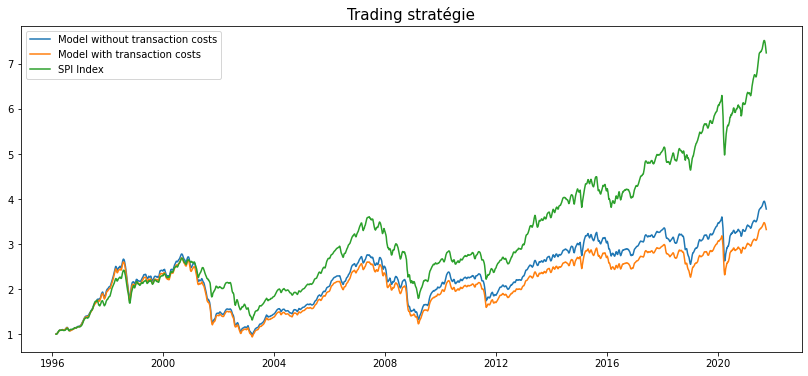

In [92]:
perf_pred_gross = pred_to_perf(df_pred, daily_returns=daily_returns, tax=0.).rename('Model without transaction costs')
perf_pred_net = pred_to_perf(df_pred, daily_returns=daily_returns, tax=0.0012).rename('Model with transaction costs')

data = pd.concat([perf_pred_gross, perf_pred_net, price_to_perf(bench_price[df_pred.index[0]:df_pred.index[-1]])], axis=1)

fig = plt.figure(figsize=(14,6))
plt.title('Trading stratégie', fontsize=15)
sns.lineplot(data=data.rolling(20).mean(), dashes=False)
plt.show()

In [93]:
rebalance_frequences = ['W', '2W', 'M', '3M']
start_date = "2010-01-03"
end_date = "2021-01-01"
index = df_price.loc[start_date:end_date].index

df_perf_strat = pd.DataFrame(index=index)
df_cost_strat = pd.DataFrame(index=index)

for freq in rebalance_frequences:
    
    df_perf_strat_freq = pred_to_perf(df_rank.shift(2).asfreq(freq=freq, method='ffill'), index=index, indices_price=indices_price)[0].rename({0:freq})
    df_perf_strat = pd.concat([df_perf_strat, df_perf_strat_freq], axis=1)
    
    # df_cost = pred_to_perf(df_rank.shift(2).asfreq(freq=freq, method='ffill'))[1]
    # df_cost_strat = pd.concat([df_cost_strat, df_cost], axis=1)
    
df_perf_strat.columns = rebalance_frequences
df_perf_strat.head()

TypeError: pred_to_perf() got an unexpected keyword argument 'index'

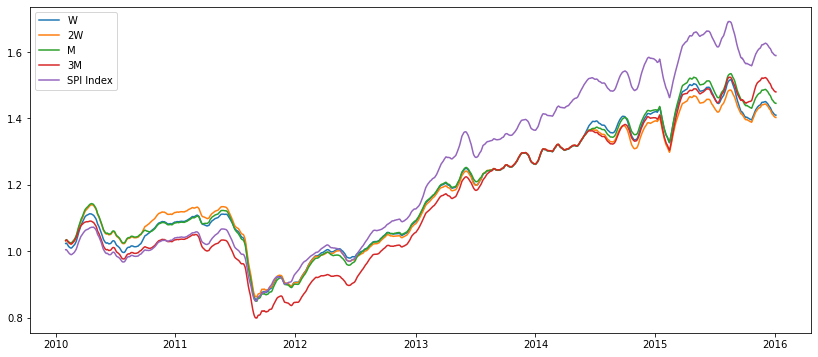

In [81]:
data_plot = pd.concat([df_perf_strat, price_to_perf(indices_price['SPI Index'].loc[index])], axis=1).rolling(30).mean().dropna()

fig, ax = plt.subplots(figsize=(14,6))
sns.lineplot(data=data_plot, dashes=False)
plt.show()

In [62]:
price_to_perf(indices_price['SPI Index'].loc[index])

2010-01-03    1.000000
2010-01-04    1.013639
2010-01-05    1.008385
2010-01-06    1.006196
2010-01-07    1.005693
                ...   
2015-12-30    1.616303
2015-12-31    1.616303
2016-01-01    1.616303
2016-01-02    1.616303
2016-01-03    1.616303
Name: SPI Index, Length: 2192, dtype: float64

In [63]:
pd.concat([df_perf_strat, price_to_perf(indices_price['SPI Index'].loc[index])], axis=1).rolling(30).mean().dropna()

,W,2W,M,3M,SPI Index
2010-02-01,1.023299,1.031419,1.032407,1.031886,1.004462
2010-02-02,1.024151,1.032678,1.033823,1.033172,1.004657
2010-02-03,1.024456,1.033389,1.034691,1.033927,1.004408
2010-02-04,1.023583,1.032913,1.034368,1.033442,1.003564
2010-02-05,1.021928,1.031647,1.033253,1.032159,1.002130
...,...,...,...,...,...
2015-12-30,1.411981,1.405018,1.447700,1.482221,1.591299
2015-12-31,1.411032,1.404074,1.446727,1.481225,1.590427
2016-01-01,1.409957,1.403004,1.445624,1.480096,1.589430
2016-01-02,1.409772,1.402820,1.445435,1.479903,1.589331
